# Training and exploring the model evaluation

Jupyter notebooks are great for orchestrating work and for interactive exploration. However, authoring code in notebooks can quickly become hard to scale and error prone. Testing and source controling solutions built on notebooks is not trivial.

In this notebook, we will explor how we can combine the practice of writing notebooks with the practice of building a Python library.

## Importing our library

Core functionality for our model is implemented in Python libraries, which allows us to use more robust testing. This project has a `pth` file configured to point to the `src` folder. Hence, any package that we created in such folder will be available for importing in the notebook.

The `carpricer` library is included in the `src` folder. The way we designed the library is structure as follows:

* `carpricer.dataprep` contains logic related to data preparation, including transformations.
* `carpricer.train` contains logic related to training and evaluating models.

In [1]:
import carpricer.dataprep as dataprep
from carpricer.dataprep import transformations
from carpricer.train import evaluator, trainer

### Model's configuration and hyperparameters
Our model's configuration is not stored in code, but in a configuration file. The choice we used here is on a `YAML` file. This makes easier to segregate configuration from code. 

Let's have a look at it:

In [2]:
!cat ../src/carpricer.params.yml

model:
  baseline: 
    objective: reg:squarederror
    min_child_weight: 4
    colsample_bytree: .7
    n_estimators: 200
  tune:
    cv: 5
    objective: neg_mean_squared_error
    search:
      learning_rate: [.003, .05, .07,]
      max_depth: [3, 20]
      alpha: [0, .5]
      subsample: [.7, 1]
data:
  label: lnprice
  test_size: 0.3


### Arguments to use

Although our hyperparameters are stored in a file, the location of the file and the location of the data we are going to use are parameters we will need to pass to the notebook. Let's use the following arguments for this example:

In [3]:
train_path = "../data/car-prices/sample/automobile_prepared.csv"
params_file = "../src/carpricer.params.yml"

> The cell above was market with a `tag` named `parameters` (To view it you have to show the tags toolbar in Jupyter Notebooks from the View menu). Cells marked with such tag are interpreted as parameters by `papermill` and hence you can run this notebook changing this parameters directly from the command line like this: `papermill notebooks/carpricer_model.ipynb --train_path data/car-prices/sample/automobile_prepared.csv --params_file src/carpricer.params.yml`

The library `jobtools` has functionalities to quickly parse a `YAML` file to a namespace object that can use the "dot notation" to access it's members. When running from the command line we don't need to load the file manually, but here since we are making an interactive run we can load it using `ParamsNamespace`.

In [4]:
from jobtools.arguments import ParamsNamespace

In [5]:
params = ParamsNamespace.load(params_file)

## Loading data and preprocessing

Let's use our preprocessing library to read the data

In [6]:
X_train, y_train, X_test, y_test = dataprep.read_and_split(train_path, 
                                                           params.data.test_size, 
                                                           params.data.label)

The method `scale_and_encode` was designed to preprocess a given dataset and also return the transformations fitted to it. This allows us to then store this transformations for when the model is deployed.

In [7]:
X_train_transformed, transforms = transformations.scale_and_encode(X_train)

Let's apply the same transformations to our testing dataset:

In [8]:
X_test_transformed = transforms.transform(X_test)

## Training routine

We will use Mlflow for tracking metrics, parameters and models in our experiments.

In [9]:
import mlflow

In [10]:
mlflow.start_run()

<ActiveRun: >

### The base model

Our base model will be an XGBoost regressor with some basic configuration. 

In [11]:
from xgboost.sklearn import XGBRegressor

We have some specific parameters for this regressor that are stored in the configuration file:

In [12]:
params.model.baseline

namespace(objective='reg:squarederror',
          min_child_weight=4,
          colsample_bytree=0.7,
          n_estimators=200)

We are going to pass this arguments to the constructor of the regressor:

In [13]:
base_model = XGBRegressor(silent=True, nthread=4, **params.model.baseline.to_dict())

As a good practice, let's log the parameters used to our experiment:

In [14]:
mlflow.log_params(params.model.baseline.to_dict()) 

### Searching for hyperparameters

We designed a method to search for hyperparameters `fit_and_optimize`. This method recieves a training dataset, a base model and a grid with all the parameters to look for:

In [15]:
search = trainer.fit_and_optimize(X_train_transformed, 
                                  y_train, 
                                  base_model=base_model,
                                  param_grid=params.model.tune.search.to_dict(),
                                  cv=params.model.tune.cv,
                                  scoring_fit=params.model.tune.objective)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[17:42:35] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.

[17:42:35] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



[17:42:35] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoos

### Evaluating the results

Searching for the best configuration for the model may require some exploration. We are using the library `sklearn_evaluation` to evaluate results.

`sklearn_evaluation` is used in the `evaluate_search` method where we pass the search results of the tunning and the parameters we are looking to explore:

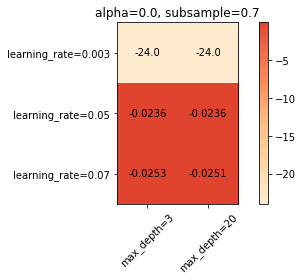

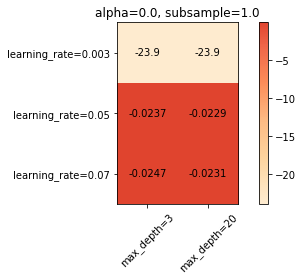

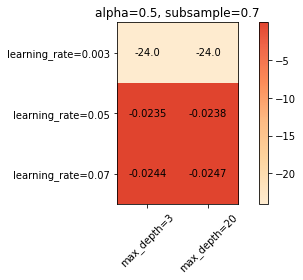

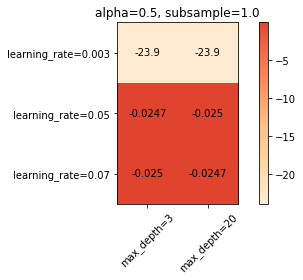

In [16]:
evaluator.evaluate_search(search, plot_params_name=['learning_rate', 'max_depth'], to_mlflow=False)

Let's fin the best model, the best parameters combination and log them with Mlflow:

In [17]:
best_model = search.best_estimator_
best_params = search.best_params_

In [18]:
mlflow.log_params(best_params)

We are going to calculate a couple of metrics for the chosen model:

In [19]:
metrics = evaluator.evaluate_regressor(best_model, X_test_transformed, y_test)

In [20]:
mlflow.log_metrics(metrics)

### Constructing the inference pipeline

Now we have a good model at hand, we can construct a pipeline with both the preprocessing step and an estimator. This pipleline can then be stored for inference:

In [21]:
from sklearn.pipeline import Pipeline

In [22]:
model_pipeline = Pipeline(steps=[('preprocessing', transforms),
                                 ('model', best_model)])

Both the transformations and the model are fitted, however, the pipeline is not. Calling `.fit` will be needed just to tell Scikit-Learn that the pipeline is good to go. No training will happen since all its components are already fitted. An alternative to doing this would be to contruct the pipeline first and train the entire pipeline instead of just the classifier. Both approaches are correct.

In [23]:
model_pipeline.fit(X_test, y_test)

[17:54:01] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_inputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['wheel-base', 'length',
                                                   'width', 'height',
                                                   'curb-weight', 'engine-size',
                                                   'bore', 'stroke',
                                                   'compression-ratio',
                                                   'horsepower', 'peak-rpm',
                                                   'city-mpg', 'highway-mpg']),
                                                 ('cat_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)...
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.05, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=20, max_leaves=0, min_child_weight=4,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=4, nthread=4,
                              num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

#### Logging the model with Mlflow

We are going to log the winning model with mlflow. First let's see which is the expected inputs and outputs of the model:

In [24]:
from mlflow.models.signature import infer_signature

In [25]:
signature = infer_signature(X_test, y_test.values)

Logging the model:

In [26]:
mlflow.sklearn.log_model(model_pipeline, "model", signature=signature)

/home/santiagxf/miniconda3/envs/carpricer/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ModelInfo(artifact_path='model', flavors={'python_function': {'model_path': 'model.pkl', 'loader_module': 'mlflow.sklearn', 'python_version': '3.8.5', 'env': 'conda.yaml'}, 'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.1.0', 'serialization_format': 'cloudpickle', 'code': None}}, model_uri='runs:/10e48cc6-d3c6-4b1b-b961-dfb6cf4e3e82/model', model_uuid='ef29445988ad41dca9a71e1f8f3a58a5', run_id='10e48cc6-d3c6-4b1b-b961-dfb6cf4e3e82', saved_input_example_info=None, signature_dict={'inputs': '[{"name": "make", "type": "string"}, {"name": "fuel-type", "type": "string"}, {"name": "aspiration", "type": "string"}, {"name": "num-of-doors", "type": "string"}, {"name": "body-style", "type": "string"}, {"name": "drive-wheels", "type": "string"}, {"name": "engine-location", "type": "string"}, {"name": "wheel-base", "type": "double"}, {"name": "length", "type": "double"}, {"name": "width", "type": "double"}, {"name": "height", "type": "double"}, {"name": "curb-weight", "type": "dou

Let's finish the experiment

In [27]:
mlflow.end_run()